In [1]:
from common import * 
import sys

/Users/thomas/.brite


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import LightCurve

plt.rcParams.update({'font.size': 15, 'xtick.labelsize': 'small', 'ytick.labelsize': 'small','ytick.direction': 'in', 'xtick.direction': 'in',  # tells matplotlib to plot the ticks inward
                     'ytick.right': True, 'xtick.top': True, # tells matplotlib to plot the ticks also on the right and on the top
                     'xtick.minor.visible': True,'ytick.minor.visible': True, # include minor ticks as well
                     'xtick.major.width': 2, 'ytick.major.width': 2 # widht of major ticks
					 , 'ytick.minor.width': 1.25, 'xtick.minor.width': 1.25, 'axes.titlesize': 'small', 'axes.labelsize' : 'small'
                      })

In [9]:
def color(path):
    if 'BAb' in path or 'BLb' in path:
        return 'royalblue'
    elif 'BHr' in path or 'UBr' in path or 'BTr' in path:
        return 'firebrick'
    else:
        raise NameError('No Satellite Name in Path: ' + path)


        
def specific_plot_create(star_name, field, satellite, do_inset=True, inset_region = (0,0), do_phasefold = True, phasefold_period = 0, do_periodogram = True, periodogram_range = (0,0) ):
    
    config_dict = get_config()
    default_result_entry = 'all'
    stars = load(field)
    print(stars)
    try:
        star = [i for i in stars if i.name == star_name][0]
    except: 
        print(f"Star name {star} not found in field {field}. Please check if spelled correct and field correct.")
        sys.exit()
    
    result_path = star.results[0]
    for dataset in star.get_all_data_sets(result_path):
        if dataset._satellite == satellite and dataset.combined:
            break
    
    
    
    orbital_periods = {'UBr': 100.3708/1440, 'BAb':  100.3617/1440, 'BTr': 98.2428/1440, 'BLb': 99.6651/1440, 'BHr':97.0972/1440}
    start_times = [0, 603.4944567391507, 741.5047292323416, 776.5054984238852, 820.5036300755875, 904.4962054965513, 924.4950121321488, 1001.4959741645878, 1097.5042068469154, 1098.5042688566396, 1174.5043762953505, 1261.496833452413, 1321.4942997357778, 1370.4962364442279, 1373.4964575226386]
    end_times = [0, 733.5042846935763, 888.4974788652289, 805.5045879538453, 985.495045537583, 1071.5022059256232, 1097.5042068469154, 1169.5046546215021, 1175.5043165046843, 1263.4966751424365, 1340.4946352750571, 1407.499449583642, 1496.505482261617, 1442.5027029357807, 1418.5005081942502]
    name = path.split('/')[-1]
    data_path = os.path.join(config_dict['Decorrelation Path'],dataset._path)
    try:
        data = Data(data_path,None)
    except:
        "Coult not load data"
        return
    
    inset_window = None
    phasefold_window = None
    periodogram_window = None
    window_index = 0
    windows = {}
    
    num_subplots = 1
    if do_inset: 
        num_subplots +=1
        windows["inset_window"]= window_index
        window_index +=1 
    if do_phasefold: 
        num_subplots +=1
        windows["phasefold_window"]= window_index
        window_index +=1 
    if do_periodogram: 
        num_subplots +=1
        windows["periodogram_window"]= window_index
        window_index +=1 
        
    print(inset_window, phasefold_window, periodogram_window)
        
    letters = ["B", "C", "D"]
    
        
    if num_subplots == 4:
        mosaic = """
                AABCD
                AABCD
                """
        final_index = "D"
    elif num_subplots == 3:
        mosaic = """
                AABC
                AABC
                """
        final_index = "C"
    elif num_subplots == 2:
        mosaic = """
                AAB
                AAB
                """
        final_index = "B"
    else :
        mosaic = """
                AA
                AA
                """
        final_index = "A"
        
    if do_inset:
        inset_window = letters[windows["inset_window"]]        
    if do_phasefold:
        phasefold_window = letters[windows["phasefold_window"]]        
    if do_periodogram:
        periodogram_window = letters[windows["periodogram_window"]]
    
    fig = plt.figure(constrained_layout=True,figsize = (15,5),dpi = 300)
    axes = fig.subplot_mosaic(mosaic)
    lk = data._lk_obj
    time_for_ave =lk.time.value
    flux_for_ave = lk.flux.value
    sort = np.argsort(time_for_ave)
    time_for_ave = time_for_ave[sort]
    flux_for_ave = flux_for_ave[sort]
    orbit_per = orbital_periods[data.satellite]
    t_0  = 0
    for i in range(len(lk.time)):
        if time_for_ave[i + 1] - time_for_ave[i] > 0.5 * orbit_per:
            t0 = time_for_ave[i + 1] - 1.45 *orbit_per 
            break
    while t0 > time_for_ave[0]:
        t0 -= orbit_per
        
    t = t0
    ave_times = []
    ave_flux = []
#     print(ave_times)
    while t < time_for_ave[-1]:
        ind = np.where(np.logical_and(time_for_ave >= t, time_for_ave <=  t + orbit_per))
        if ind[0].size > 1:
            ave_times.append(np.mean(time_for_ave[ind]))
            ave_flux.append(np.median(flux_for_ave[ind]))
        t += orbit_per
    
    
    ave_lk = LightCurve(ave_times, ave_flux)
#     print(ave_times)
    
#     figs, ax = plt.subplots()
#     ax.plot(time_for_ave[:150], flux_for_ave[:150], 'ko')
#     ax.plot(ave_times[:10], ave_flux[:10], 'ro', ms = 5)
#     for i in range(10):
#         ax.axvline(t0+i*orbit_per)
#     plt.show()
#     return

    
    do_ave = True
#     try:
#         ave_lk = data._ave_lk_obj
#     except OS_Error:
#         do_ave = False
    
#     if ave_lk is None:
#         do_ave = False
    if do_inset:
        if inset_region == (0,0):
            zoom_in = lk[abs(lk.time.value - np.median(lk.time.value)) <= 5]

            center_time = np.median(lk.time.value)
            zoom_in_2 = lk[abs(lk.time.value - np.median(lk.time.value) - 10) <= 5]
            if len(zoom_in_2.time.value) > len(zoom_in.time.value):
                zoom_in = zoom_in_2
                center_time = np.median(lk.time.value) -10 
            zoom_in_3 = lk[abs(lk.time.value - np.median(lk.time.value) + 10) <= 5]
            if len(zoom_in_3.time.value) > len(zoom_in.time.value):
                zoom_in = zoom_in_3
                center_time = np.median(lk.time.value) + 10 
            zoom_in_4 = lk[abs(lk.time.value - np.median(lk.time.value) + 20) <= 5]
            if len(zoom_in_4.time.value) > len(zoom_in.time.value):
                zoom_in = zoom_in_4
                center_time = np.median(lk.time.value) + 20
            zoom_in_5 = lk[abs(lk.time.value - np.median(lk.time.value) - 20) <= 5]
            if len(zoom_in_3.time.value) > len(zoom_in.time.value):
                zoom_in = zoom_in_3
                center_time = np.median(lk.time.value) - 20 
        else:
            zoom_in = lk[abs(lk.time.value - (inset_region[0] + 0.5*(inset_region[1]-inset_region[0]))) <= 0.5*(inset_region[1]-inset_region[0])]                            
            
    
    
    c = color(satellite)

    axes["A"].plot(lk.time.value, lk.flux.value, 'ko', ms = 0.5, alpha = 0.5, rasterized = True)
    if do_inset:
        try:
            axes["A"].axvline(np.min(zoom_in.time.value), color = 'silver', lw = 1, ls = '--', zorder = 5)
            axes["A"].axvline(np.max(zoom_in.time.value), color = 'silver', lw = 1, ls = '--', zorder = 5)
        except IndexError:
            pass
    if do_inset:
        axes[inset_window].plot(zoom_in.time.value, zoom_in.flux.value, 'ko', ms = 0.5, alpha = 0.5, rasterized = True)
    axes["A"].set_xlim(start_times[field]-5, end_times[field]+5)
    if do_ave:
        try:    
            if do_inset:
                if inset_region == (0,0):
                    ave_zoom_in = ave_lk[abs(ave_lk.time.value - np.min(zoom_in.time.value) - 5) <= 5]
                else:
                    ave_zoom_in = ave_lk[abs(ave_lk.time.value - (inset_region[0] + 0.5*(inset_region[1]-inset_region[0]))) <= 0.5*(inset_region[1]-inset_region[0])]
                
            if do_inset:        
                axes[inset_window].plot(ave_zoom_in.time.value, ave_zoom_in.flux.value,  color = c, ls = '', marker = 'o',  ms = 1.5, alpha = 0.75, rasterized = True)
            axes["A"].plot(ave_lk.time.value, ave_lk.flux.value,  color = c, ls = '', marker = 'o', ms = 1.5, alpha = 0.75, rasterized = True)
        except IndexError:
            pass
    if do_inset:
        axes[inset_window].set_xlim(np.min(zoom_in.time.value), np.max(zoom_in.time.value))
    
    pdg = data.to_periodogram(minimum_frequency = 0.1, maximum_frequency = 100)
    period = pdg.period_at_max_power.value
    # print(period)
    
    if phasefold_period != 0:
        period = phasefold_period
    if do_phasefold:
        axes[phasefold_window].plot((lk.time.value%period)/period, lk.flux.value, 'ko', ms = 0.5, alpha = 0.5, rasterized = True)
        axes[phasefold_window].plot((lk.time.value%period)/period + 1, lk.flux.value, 'ko', ms = 0.5, alpha = 0.5, rasterized = True)

    if do_periodogram:                            
        axes[periodogram_window].axvline(1/period, color = c, lw = 2, ls = '-')
        if periodogram_range == (0,0):
            pdg = data.to_periodogram(minimum_frequency = 0.1, maximum_frequency = np.max([10, 2/period]), oversample_factor = 2)
        else:
            pdg = data.to_periodogram(minimum_frequency = periodogram_range[0], maximum_frequency = periodogram_range[1], oversample_factor = 2)
        axes[periodogram_window].plot(pdg.frequency, pdg.power, 'k-', lw = 1)
        if periodogram_range == (0,0):
            axes[periodogram_window].set_xlim(0, np.max([10, 2/period]))
        else:
            axes[periodogram_window].set_xlim(periodogram_range[0], periodogram_range[1])
            
    
    if do_ave and do_phasefold:
        axes[phasefold_window].plot((ave_lk.time.value%period)/period, ave_lk.flux.value, color = c, ls = '', marker = 'o', ms = 1.5, alpha = 0.75, rasterized = True)
        axes[phasefold_window].plot((ave_lk.time.value%period)/period + 1, ave_lk.flux.value, color = c, ls = '', marker = 'o', ms = 1.5, alpha = 0.75, rasterized = True)

    if do_inset and inset_region == (0,0):
        axes[inset_window].set_yticklabels([])
    
    
        try:
            x1 = np.round(zoom_in.time.value[0] + 2, 0)
            x3 = np.round(zoom_in.time.value[0] + 8, 0)
            x2 = np.round((x1 + x3)/2, 0)
            axes[inset_window].set_xticks([x1, x2, x3])
        except IndexError:
            pass
                                             
    if do_phasefold:
        axes[phasefold_window].set_yticklabels([])
    if final_index != "A":
        axes[final_index].yaxis.tick_right()
        axes[final_index].yaxis.set_label_position('right')
    
                                             
    for a in ["A", "B", "C", "D"]:
        if a!= periodogram_window:
            axes[a].invert_yaxis()
        if a == final_index:
            break
                                             
    axes["A"].set_xlabel("time (days)")
    if do_inset:
        axes[inset_window].set_xlabel("time (days)")
    if do_phasefold:
        axes[phasefold_window].set_xlabel("phase P={:3f} d".format(period))
    if do_periodogram:
        axes[periodogram_window].set_xlabel("frequency ($d^{-1}$)")
        axes[periodogram_window].set_ylabel("Power")
#         if do_phasefold
#         axes["D"].set_title("f={:3f} ".format(1/period) + '${\\rm d}^{-1}$')
    axes["A"].set_ylabel("Magnitude")
    # axes["D"].set_title("f={:3f} ".format(1/period) + '${\\rm d}^{-1}$')
    ylim = axes["A"].get_ylim()
                                                                                          
    for a in [ "B", "C", "D"]:
        if a == final_index:
            break
        axes[a].set_ylim(ylim)
#     axes["A"].set_title(data.starname + "   " + data.satellite + "    Field:" + data.field)
    # plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0, left = 0.05, right = 0.95, top = 0.85, bottom = 0.175)

#     if line_top:

#         axes["A"].annotate('', xy=(-1, 1.15), xycoords='axes fraction', xytext=(5, 1.175),
#                     arrowprops=dict(arrowstyle="-", color='k', lw = 3))

    plt.show()


[HD 44402, HD 44743, HD 45871, HD 46328, HD 48917, HD 49131, HD 50013, HD 50123, HD 50707, HD 50877, HD 50896, HD 51309, HD 52089, HD 52670, HD 52877, HD 53138, HD 53244, HD 54309, HD 54605, HD 56014, HD 56139, HD 57060, HD 57061, HD 58155, HD 58286, HD 58343, HD 58350, HD 61068, HD 62623, HD 62747, HD 63462, HD 67523]
None None None


TypeError: 'int' object is not subscriptable

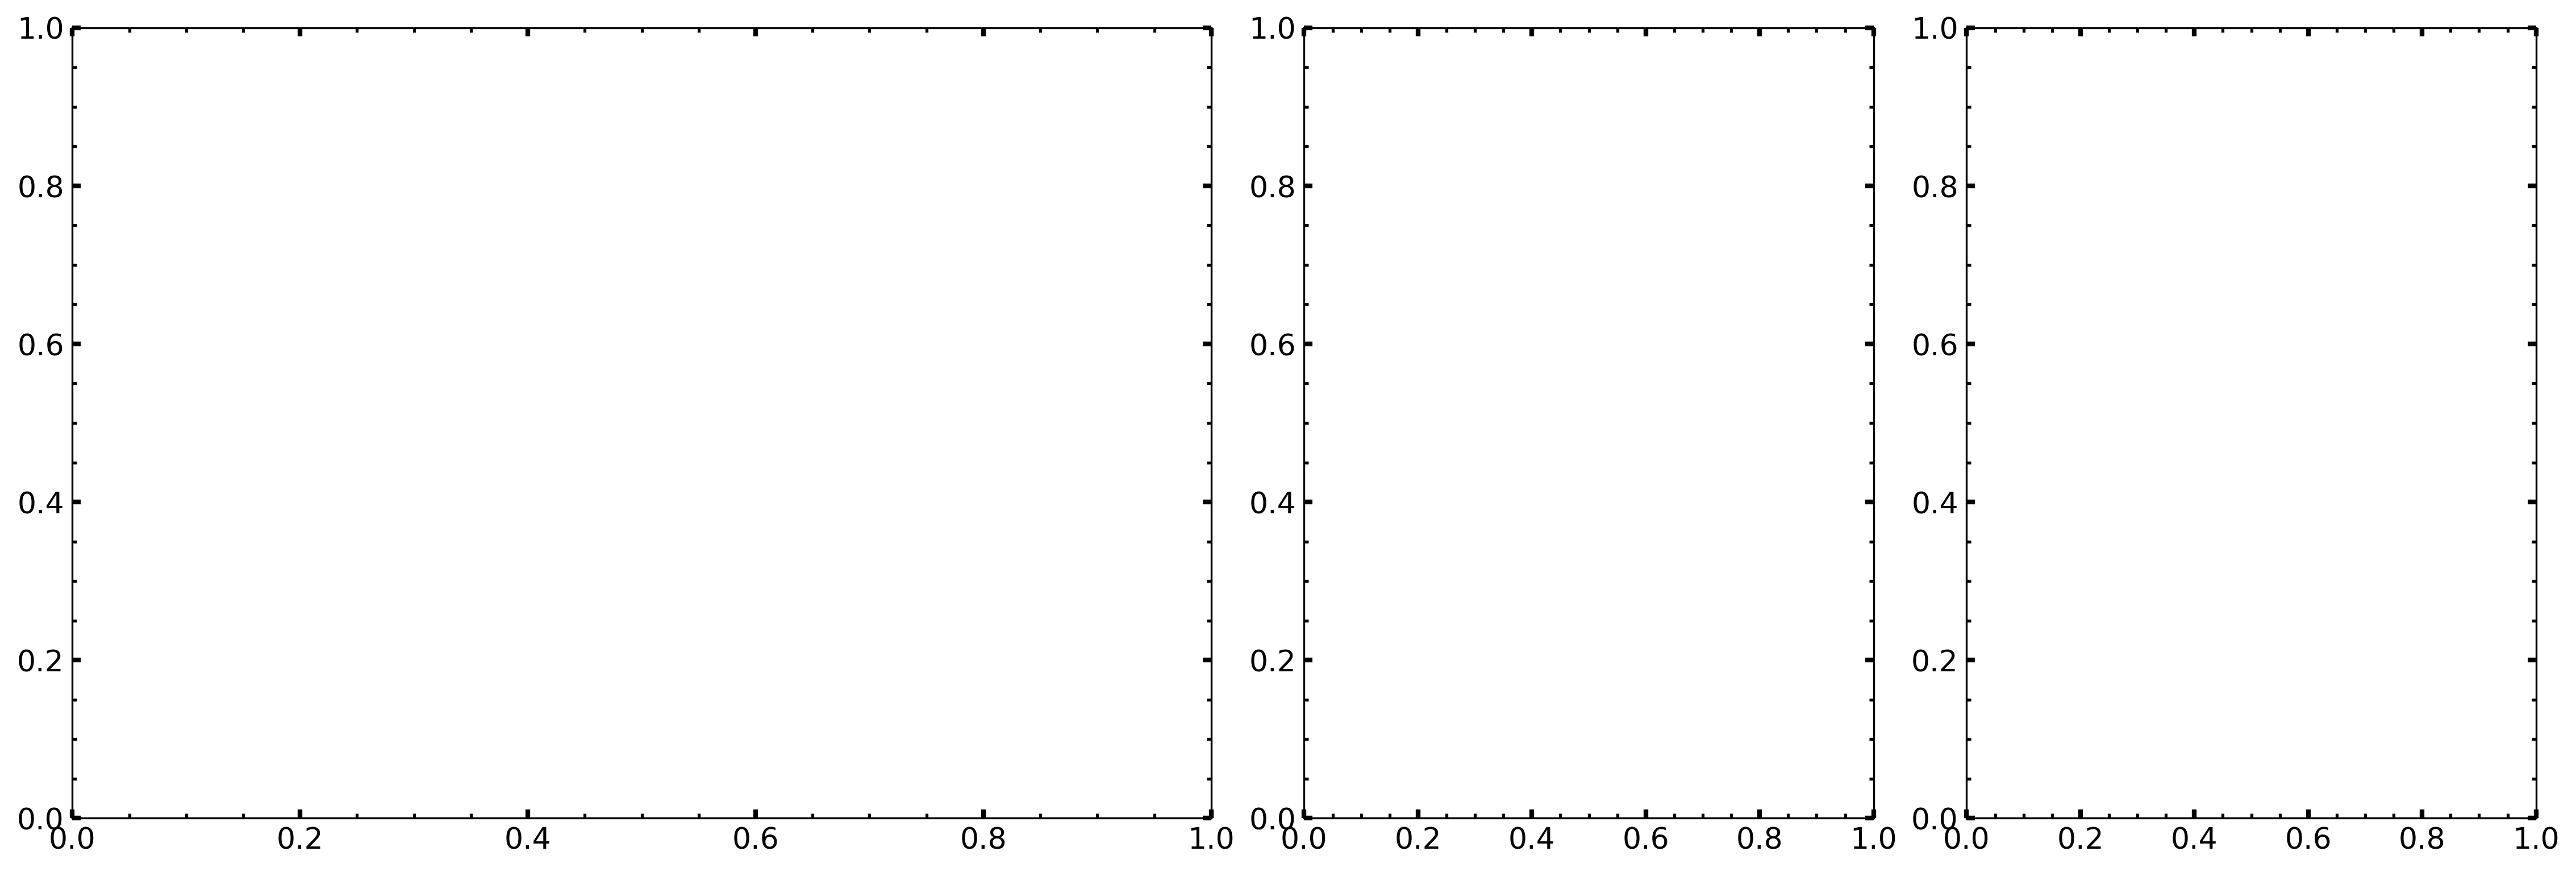

In [16]:

specific_plot_create("HD 50123", 12, "BTr", do_inset=True, inset_region = (0,0), do_phasefold = True, phasefold_period = 0, do_periodogram = False, periodogram_range = (0,50) )
   